<h1>Optimized analysis of WMLs using MRI</h1>

In [2]:
%%HTML
<h1>Imports</h1>

In [3]:
#coding=utf-8
#matplotlib.use('Agg')

from numpy import *
import numpy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import color
import dicom
from io import StringIO
import sys


import glob, urllib, os
from ia636 import iaconv, ianormalize, iamosaic, iagshow,iaimginfo, iaffine
from ia870 import iagradm, iaareaopen, iaareaclose, ialabel, iadist, iasedisk, iasecross, iasubm, iadil, iaero
from skimage.feature import local_binary_pattern
from sklearn.feature_extraction import image
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import svm,neighbors,preprocessing
from sklearn import metrics

from skimage import exposure
import skimage.transform

from joblib import Parallel, delayed
import multiprocessing

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn import linear_model

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 


from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import cross_val_score

from sklearn.grid_search import GridSearchCV
from sklearn import decomposition
from sklearn.decomposition import PCA,IncrementalPCA

import time
import timeit
import warnings
import datetime
from time import gmtime, strftime
from copy import deepcopy

warnings.filterwarnings("ignore")

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
%%HTML
<h1>Support Functions</h1>

In [5]:
def write(msg):
	print msg
	execution_log.write(msg + "\n")

def write_table(msg):
	execution_results.write(msg + "\n")

def write_double(msg):
	write(msg)
	write_table(msg)

def write_double_fim():
	msg = ("-------------------" * 3)
	write_double(msg)

def write_line(msg):
	print (msg + "\n" + line)
	execution_log.write(msg + "\n" + line + "\n")

def write_double_line(msg):
	print (line + "\n" + msg + "\n" + line)
	execution_log.write(line + "\n" + msg + "\n" + line + "\n")

def write_line_fim(msg):
	print (msg + "\n" + line + "\n" + line)
	execution_log.write(msg + "\n" + line + "\n" + big_line + "\n" + line + "\n" + "\n" + "\n")
	execution_results.write(msg + "\n" + line + "\n" + big_line + "\n" + line + "\n" + "\n" + "\n")

def write_results(results):
	write_double("Result for each user ID:")
	separate("-", 86)
	for result in results:
		write_double("|id: " + str(format(result[0], "02d")) + "|Acuracy: " + str(format(result[1], "5.3f")) + "| Dice without post-processing: " + str(format(result[2], "5.3f")) + "|std: " + str(format(result[3], "5.3f")) + "| Dice with post-processing: " + str(format(result[4], "5.3f")) + "|std: " + str(format(result[5], "5.3f")) + "|")
	separate("-",86)

def close_files():
	execution_log.close()
	execution_results.close()


def separate(separator, n):
	msg = str(separator * n)
	write(msg)
	write_table(msg)

In [6]:
%%HTML
<h1>Program Functions</h1>

In [7]:
####################################################
####################################################
#Function: gradimg (from local_texture)
#Goal: generate gradient of an image
#Input: image f
#Output: gradient of image f
####################################################
####################################################

def gradimg(f):        
        if len(f.shape) == 2:                                    # 2D case
            h1 = array([[0,1,0],                                 # Defining the horizontal mask
                       [0,0,0],
                       [0,-1,0]])
            h2 = array([[0,0,0],                                 # Defining the vertical mask
                       [1,0,-1],
                       [0,0,0]])
    
            aux1 = iaconv(f,h1)[1:-1,1:-1].astype(int)        # Make the convolution between horizontal mask and image
            aux2 = iaconv(f,h2)[1:-1,1:-1].astype(int)        # Make the convolution between vertical mask and image
            g = sqrt(aux1**2 + aux2**2)                       # Use the equation to compute the gradient of an image
            
            return g
            
        else:                                                    # 3D case
            h1 = array([[[0,0,0],                                # Defining the horizontal mask 
                         [0,0,0],
                         [0,0,0]],
                        [[0,1,0],
                         [0,0,0],
                         [0,-1,0]],
                        [[0,0,0],
                         [0,0,0],
                         [0,0,0]]])
            h2 = array([[[0,0,0],                                # Defining the vertical mask
                         [0,0,0],
                         [0,0,0]],
                        [[0,0,0],
                         [1,0,-1],
                         [0,0,0]],
                        [[0,0,0],
                         [0,0,0],
                         [0,0,0]]])
            h3 = array([[[0,0,0],                                # Defining the depth mask
                         [0,1,0],
                         [0,0,0]],
                        [[0,0,0],
                         [0,0,0],
                         [0,0,0]],
                        [[0,0,0],
                         [0,-1,0],
                         [0,0,0]]])  
    
            aux1 = iaconv(f,h1)[1:-1,1:-1,1:-1].astype(int)    # Make the convolution between horizontal mask and image 
            aux2 = iaconv(f,h2)[1:-1,1:-1,1:-1].astype(int)    # Make the convolution between vertical mask and image
            aux3 = iaconv(f,h3)[1:-1,1:-1,1:-1].astype(int)    # Make the convolution between depth mask and image
            grad = sqrt(aux1**2 + aux2**2 + aux3**2)              # Use the equation to compute the gradient of an image
            return grad  



####################################################
####################################################
#Function: resize
#Goal: changes the dimension of the images
#Input: img, slices
#Output: img (imagem redimensionada)
####################################################
####################################################

def resize(img, slices):
	if (img.shape[1] > size_slice and img.shape[2] > size_slice):
		return skimage.transform.resize(img, (slices,size_slice,size_slice))
	elif (img.shape[1] == size_slice and img.shape[2] == size_slice):
		return img
	else:
		sys.exit(1)


#####################################################
#####################################################
#Function: generate_images_pre_processing
#Goal: performs pre-processing of the images
#Input: img_org, img_wm, img_wml
#Output: img_org, img_wm, img_wml
#####################################################
#####################################################

def generate_images_pre_processing(img_org, img_wm, img_wml):
	#resize
	slices = img_org.shape[0]
	img_org = resize(img_org, slices)
	img_wm = resize(img_wm, slices)
	img_wml = resize(img_wml, slices)

	#normalize the image
	img_org = ianormalize(img_org)

	return (img_org, img_wm, img_wml)


####################################################
####################################################
#Function: print_infos_start_program
#Goal: print information about the program
#Input: -
#Output: -
####################################################
####################################################

def print_infos_start_program():
	execution_log.write(line + "\n")
	print line
	
	write_double("Start of the program")
	print line

	data_local = time.localtime()
	year = str(data_local[0])
	month = data_local[1]
	day = data_local[2]
	hour = data_local[3]
	minute = data_local[4]
	second = data_local[5]


	current_date = (str(format(day, "02d")) + "/" + str(format(month, "02d")) + "/" + str(year))
	current_time = (str(format(hour, "02d")) + ":" + str(format(minute, "02d")) + ":" + str(format(second, "02d")))

	#Prints date and time
	write_line("Day: " + str(current_date))
	write_line("Time: " + str(current_time))

	#prints the number of processors
	write_line("Num CPUs: " + str(num_cores))



###############################################################
###############################################################
#Function: print_lists_patients_training_and_test
#Goal: prints list of patients for training and testing
#Input: list of patients for training and testing
#Output: -
###############################################################
###############################################################

def print_lists_patients_training_and_test(id_list_training, id_list_testing):

	#IDs for training
	num_elements_training=len(id_list_training)
	write_double("Number of elements for training: " + str(num_elements_training))

	write_double("IDs for training:")

	for id in id_list_training:
		print id,
		execution_log.write(str(id) + " ")
		execution_results.write(str(id) + " ")

	write_double("\n" + line)


	#IDs for testing
	num_elements_testing=len(id_list_testing)
	write_double("Number of elements for testing: " + str(num_elements_testing))

	write_double("IDs for testing:")

	for id in id_list_testing:
		print id,
		execution_log.write(str(id) + " ")
		execution_results.write(str(id) + " ")

	write_double("\n" + line)




###################################################
###################################################
#Function: boxplot
#Goal: prints boxplot of the testing patients
#Input: dice_total_testing, labels=list_testing_wml
#Output: -
###################################################
###################################################

def boxplot(dice_total_testing, list_testing_wml):
	plt.xlabel('Testing Patients')
	plt.ylabel('Dice Coefficient')
	plt.ylim([0.0, 1.0])
	plt.boxplot(dice_total_testing, labels=list_testing_wml)
	plt.title("Boxplot")
	plt.savefig(path_box_plot_folder)
	plt.show(dice_total_testing)



###########################################################################
###########################################################################
#Function: generate_mosaics
#Goal: creates 3D Mosaics of the testing patients
#Input: user_id, img_wml, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing
#Output: -
############################################################################
############################################################################

def generate_mosaics(user_id, img_wml, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing):

	#3D mosaic img_wml1
	img_temp = img_wml[0:50,:,:]
	img_wml1 = ianormalize(iamosaic(img_temp,5))

	#3D mosaic img_wml2
	img_temp = img_wml[50:100,:,:]
	img_wml2 = ianormalize(iamosaic(img_temp,5))

	#3D mosaic img_wml3
	img_temp = img_wml[100:,:,:]
	img_wml3 = ianormalize(iamosaic(img_temp,5))




	#3D mosaic img_prediction1
	img_temp = prediction_matrix_without_post_processing[0:50,:,:]
	img_prediction1 = ianormalize(iamosaic(img_temp,5))

	#3D mosaic img_prediction2
	img_temp = prediction_matrix_without_post_processing[50:100,:,:]
	img_prediction2 = ianormalize(iamosaic(img_temp,5))

	#3D mosaic img_prediction3
	img_temp = prediction_matrix_without_post_processing[100:,:,:]
	img_prediction3 = ianormalize(iamosaic(img_temp,5))




	#3D mosaic img_prediction_pos1
	img_temp = prediction_matrix_with_post_processing[0:50,:,:]
	img_prediction_pos1 = ianormalize(iamosaic(img_temp,5))

	#3D mosaic img_prediction_pos2
	img_temp = prediction_matrix_with_post_processing[50:100,:,:]
	img_prediction_pos2 = ianormalize(iamosaic(img_temp,5))

	#3D mosaic img_prediction_pos3
	img_temp = prediction_matrix_with_post_processing[100:,:,:]
	img_prediction_pos3 = ianormalize(iamosaic(img_temp,5))




	
	plt.imshow(img_wml1, cmap='Greys_r')
	plt.title(" id "+str(user_id)+" | wml1 0-50")
	plt.savefig(path_mosaics_folder+str(user_id)+"/1)wml_0_50")

	plt.imshow(img_prediction1, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | img prediction 1 without post-processing 1 0-50")
	plt.savefig(path_mosaics_folder+str(user_id)+"/2)prediction_without_post_0_50")

	plt.imshow(img_prediction_pos1, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | img prediction 1 with post-processing 0-50")
	plt.savefig(path_mosaics_folder+str(user_id)+"/3)prediction_with_post_0_50")



	
	plt.imshow(img_wml2, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | wml2 50-100")
	plt.savefig(path_mosaics_folder+str(user_id)+"/4)wml_50_100")

	plt.imshow(img_prediction2, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | img prediction 2 without post-processing 50-100")
	plt.savefig(path_mosaics_folder+str(user_id)+"/5)prediction_without_post_50_100")

	plt.imshow(img_prediction_pos2, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | img prediction 2 with post-processing 50-100")
	plt.savefig(path_mosaics_folder+str(user_id)+"/6)prediction_with_post_50_100")




	plt.imshow(img_wml3, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | wml3 100-154")
	plt.savefig(path_mosaics_folder+str(user_id)+"/7)wml_100_154")

	plt.imshow(img_prediction3, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | img prediction 3 without post-processing 100-154")
	plt.savefig(path_mosaics_folder+str(user_id)+"/8)rediction_without_post_100_154")

	plt.imshow(img_prediction_pos3, cmap='Greys_r')
	plt.title(" id " +str(user_id)+ " | img prediction 3 with post-processing 100-154")
	plt.savefig(path_mosaics_folder+str(user_id)+"/9)prediction_with_post_100_154")



######################################################################################################################################
######################################################################################################################################
#Function: generate_color_maps
#Goal: generates color map of the desired slice of a patient
#Input: user_id, img_org, img_wml, prediction_probability_matrix, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing, desired_slice
#Output: -
#######################################################################################################################################
#######################################################################################################################################

def generate_color_maps(user_id, img_org, img_wml, prediction_probability_matrix, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing, desired_slice):

	plt.imshow(img_org[desired_slice], cmap='Greys_r')
	plt.title("Original Image")
	plt.savefig(path_color_maps_folder+str(user_id)+"/"+str(desired_slice)+"/Original Image")


	plt.imshow(img_wml[desired_slice], cmap='Greys_r')
	plt.title("WML Image")
	plt.savefig(path_color_maps_folder+str(user_id)+"/"+str(desired_slice)+"/WML Image")


	plt.imshow(prediction_matrix_without_post_processing[desired_slice], cmap='Greys_r')
	plt.title("Prediction without post-processing")
	plt.savefig(path_color_maps_folder+str(user_id)+"/"+str(desired_slice)+"/Prediction without post-processing")
	

	plt.imshow(prediction_matrix_with_post_processing[desired_slice], cmap='Greys_r')
	plt.title("Prediction with post-processing")
	plt.savefig(path_color_maps_folder+str(user_id)+"/"+str(desired_slice)+"/Prediction with post-processing")


	plt.imshow(1.0*prediction_probability_matrix[desired_slice]/prediction_probability_matrix[desired_slice].max())
	plt.colorbar()
	plt.title("Color Probability")
	plt.savefig(path_color_maps_folder+str(user_id)+"/"+str(desired_slice)+"/Color Probability")





######################################################################
######################################################################
#Function: generate_slice_post_processing
#Goal: performs post-processing on a slice of the prediction matrix
#Input: prediction_slice_matrix
#Output: slice_prediction_matrix_with_post_processing
######################################################################
######################################################################

def generate_slice_post_processing(prediction_slice_matrix):
	#copies slice
	slice_prediction_matrix_with_post_processing = prediction_slice_matrix

	#connects regions disconnected by a maximum amount of the specified number of pixels
	slice_prediction_matrix_with_post_processing = iaareaclose(slice_prediction_matrix_with_post_processing,size_closed_area)

	#the method ignores regions with less than a specified number of pixels of lesion
	slice_prediction_matrix_with_post_processing = iaareaopen(slice_prediction_matrix_with_post_processing,size_opened_area)

	
	#the method ignores regions that do not fit on a unitary radius disk
	prob_mask_pred = slice_prediction_matrix_with_post_processing
	mask_pred_label = ialabel(slice_prediction_matrix_with_post_processing)  # separate lesions
	nrois = len(np.unique(mask_pred_label))-1 # background
	for id_les in arange(0,nrois):
		roi = zeros_like(slice_prediction_matrix_with_post_processing)
		roi[mask_pred_label==id_les+1] = 1
		prob_mask_pred[roi>0] = prob_mask_pred[roi>0].mean()

		#if it fits on a unitary radius disk
		if iadist(roi>0,iasedisk(1),'EUCLIDEAN').max()<2:
			slice_prediction_matrix_with_post_processing[roi]=0

	return slice_prediction_matrix_with_post_processing


#################################################################################
#################################################################################
#Function: read_dcm
#Goal: reads and returns Dicom images (original, wm mask and wml mask)
#Input: user_id (id do paciente)
#Output: img_org, img_wm, img_wml
#################################################################################
#################################################################################

def read_dcm(user_id):
	filename_img = ("%s/%d/FLAIR.dcm" % (path_miccai_images_folder, user_id)) #3D original image
	dataset_img = dicom.read_file(filename_img)
	img_org = dataset_img.pixel_array.astype(float)

	filename_wml = ("%s/%d/WML.dcm" % (path_miccai_images_folder, user_id)) #3D image with lesions
	dataset_wml = dicom.read_file(filename_wml)
	img_wml = dataset_wml.pixel_array.astype(bool)

	img_wm = (np.zeros_like(img_org)).astype(bool)
	for current_slice in range (img_wm.shape[0]):
		filename_wm = ("%s/%d/WM-mask/IM-0001-%04d.dcm" % (path_miccai_images_folder, user_id, (current_slice+1)))
		dataset_wm = dicom.read_file(filename_wm)
		img_wm[current_slice] = dataset_wm.pixel_array.astype(bool)

	return (img_org, img_wm, img_wml)



##############################################################################################################
##############################################################################################################
#Function: extract_attributes_slice
#Goal: extract attributes of a given slice of a given patient
#Input: user_id, flag_training_or_testing, img_org, img_wm, slice_wml, current_slice, slices
#Output: data_userid_slice, n_pixels_wml_slice, n_pixels_used_wm_not_wml_slice, n_total_pixels_wm_slice
##############################################################################################################
##############################################################################################################

def extract_attributes_slice (user_id, flag_training_or_testing, img_org, img_wm, slice_wml, current_slice, slices):

	#initialize variables
	data_userid_slice = []
	n_pixels_wml_slice=0
	n_pixels_used_wm_not_wml_slice=0
	n_total_pixels_wm_slice=0

	#analyse an individual slices
	slice_org = img_org[current_slice]
	slice_maskwm = img_wm[current_slice]


	#features
	lbp_img = local_binary_pattern(slice_org, n_points, radius, method)
	grad_img = gradimg(slice_org)
	mgrad_img = iagradm(slice_org)


	#training
	if (flag_training_or_testing == 0):
		#pre-processing	
		#ignores pixels where intensity<wmmean
		#ignores pixels where there are less than "method_threshold" concatenated pixels
		mean_wm = slice_org[slice_maskwm==1].mean()
		slice_maskwm2 = logical_and(iaareaopen((slice_org>mean_wm),method_threshold),slice_maskwm)


		#pre-processing to possibly reduce the number of wm_nao_wml pixels
		#Modo 0 ou 1
		if (operation_mode == 0 or operation_mode == 1):
			wm_nao_wml = slice_maskwm2

		#mode 2
		elif (operation_mode == 2):
			#dilation of wml using a cross of size 2
			cross2 = iasecross(size_cross_2)
			wm_nao_wml = iasubm(slice_maskwm2, iadil(slice_wml>0,cross2))

		#mode 3
		elif (operation_mode == 3):
			#erosion of wml using a cross of size 1
			cross1 = iasecross(size_cross_1)
			wm_nao_wml = iaero(slice_maskwm2,cross1)

		#mode 4
		elif (operation_mode == 4):
			#dilation of wml using a cross of size 2
			#erosion of wml using a cross of size 1
			cross2 = iasecross(size_cross_2)
			cross1 = iasecross(size_cross_1)
			wm_nao_wml = iasubm(iaero(slice_maskwm2,cross1), iadil(slice_wml>0,cross2))



		#creates a list with wm pixels after pre-processing	
		ind_class = argwhere(slice_maskwm2 == 1)
		for ind_mask in xrange(len(ind_class)):
			x = ind_class[ind_mask,0] #coordeinate x of the pixels in the mask of wm validated
			y = ind_class[ind_mask,1] #coordinate y of the pixels in the mask of wml validated
		   
		
			#total number of pixels wm
			n_total_pixels_wm_slice+=1
		
			#data paremeters:
			#[user id, current_slice, x, y, intensity, inferior slice intensity, superior slice intensity, lbp, grad, mgrad, average]

			#if the pixel represents a lesion
			if (slice_wml[x,y] > 0.5):
				n_pixels_wml_slice+=1 #number of lesions

				#inferior slice
				if (current_slice==0):
				   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],slice_org[x,y],img_org[current_slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])
				#superior slice
				elif (current_slice==(slices-1)):
				   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],slice_org[x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])
				else:
				  data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],img_org[current_slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])

			#if the pixel does not represents a lesion
			else:
				#it only considers the pixel if it is in the area defined by wm_nao_wml
				if (wm_nao_wml[x,y]):
					n_pixels_used_wm_not_wml_slice+=1
				
					#inferior slice
					if (current_slice==0):
						data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],slice_org[x,y],img_org[current_slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])
					#superior slice
					elif (current_slice==(slices-1)):
					   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],slice_org[x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,0])
					else:
					   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],img_org[current_slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,0])


		return (data_userid_slice, n_pixels_wml_slice, n_pixels_used_wm_not_wml_slice, n_total_pixels_wm_slice)



	elif (flag_training_or_testing == 1):
		#pre-processing
		#eliminates pixels where intensity<wmmean
		#eliminates regions where there are less than 10 concatenated pixels
		mean_wm = slice_org[slice_maskwm==1].mean()
		slice_maskwm2 = logical_and(iaareaopen(slice_org,method_threshold),slice_maskwm)
		

		#creates a list of wm pixels after the pre-processing
		ind_class = argwhere(slice_maskwm2 == 1)
		for ind_mask in xrange(len(ind_class)):
			x = ind_class[ind_mask,0] #x coordinate of the do pixel na máscara de wm válidos
			y = ind_class[ind_mask,1] #y coordinate of the y do pixel na máscara de wm válidos
		   
		
			#number of wm pixels
			n_total_pixels_wm_slice+=1
		
			#data parameters:
			#[user id, current_slice, x, y, intensity, inferior slice intensity, superior slice intensity, lbp, grad, mgrad, average]

			#se o pixel for lesão
			if (slice_wml[x,y] > 0.5):
				n_pixels_wml_slice+=1 #number of lesions

				#slice de baixo
				if (current_slice==0):
				   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],slice_org[x,y],img_org[slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])
				#slice de cima
				elif (current_slice==(slices-1)):
				   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],slice_org[x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])
				else:
				  data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],img_org[current_slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])

			#se o pixel não for lesão
			else:
				n_pixels_used_wm_not_wml_slice+=1
			
				#slice de baixo
				if (current_slice==0):
					data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],slice_org[x,y],img_org[slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,1])
				#slice de cima
				elif (current_slice==(slices-1)):
				   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],slice_org[x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,0])
				else:
				   data_userid_slice.append([user_id,current_slice,x,y,slice_org[x,y],img_org[current_slice-1,x,y],img_org[current_slice+1,x,y],lbp_img[x,y],grad_img[x,y],mgrad_img[x,y],mean_wm,0])


		return (data_userid_slice, n_pixels_wml_slice, n_pixels_used_wm_not_wml_slice, n_total_pixels_wm_slice)



	else:
		sys.exit(1)




##########################################################
##########################################################
#Function: calculate_dice_slice
#Goal: calculates the dice coefficient for a given slice
#Input: img_wml_slice, prediction_slice_matrix
#Output: ds (dice of a slice)
##########################################################
##########################################################

def calculate_dice_slice(img_wml_slice, prediction_slice_matrix):
	#calculates dividend and divider using the standard dice formula
	dividend = (1.0*(logical_and(img_wml_slice,(prediction_slice_matrix)).sum()))
	divider = (1.0*((img_wml_slice.sum()+(prediction_slice_matrix).sum())))
	if (divider == 0):
		ds = 0.0
	else:
		ds = 2.0*(dividend/divider)

	#print "%s" % (ds)
	return ds




#############################################
#############################################
#Function: extract_attributes_training
#Goal: extract attributes for a patient
#Input: user_id
#Output: data_userid
#############################################
#############################################

def extract_attributes_training(user_id):

	img_org, img_wm, img_wml = read_dcm(user_id)
	slices = img_org.shape[0]

	#training
	flag_training_or_testing = 0
	
	#initialize variables
	n_pixels_wml = 0
	n_pixels_used_wm_not_wml = 0
	n_total_pixels_wm = 0
	
	#user_id data
	data_userid = []
	
	img_org, img_wm, img_wml = generate_images_pre_processing(img_org, img_wm, img_wml)

	for current_slice in xrange(slices):
		#ignores regions with less than a specified number of pixels of lesion (prediction_matrix)
		slice_wml = iaareaopen(img_wml[current_slice],method_threshold)
		
		#ignores regions that do not fit on a unitary radius disk
		prob_mask_pred = slice_wml
		mask_pred_label = ialabel(slice_wml)  # mask with lesions
		nrois = len(np.unique(mask_pred_label))-1 # background
		for id_les in arange(0,nrois):
			roi = zeros_like(slice_wml)
			roi[mask_pred_label==id_les+1] = 1
			prob_mask_pred[roi>0] = prob_mask_pred[roi>0].mean()
			if iadist(roi>0,iasedisk(1),'EUCLIDEAN').max()<2: # se cabe um disco de raio unitário
				slice_wml[roi]=0
		

		#updates slice
		img_wml[current_slice] = slice_wml


		#if there are lesion pixels
		if (slice_wml.sum() > 0):
			data_userid_slice, n_pixels_wml_slice, n_pixels_used_wm_not_wml_slice, n_total_pixels_wm_slice = extract_attributes_slice (user_id, flag_training_or_testing, img_org, img_wm, slice_wml, current_slice, slices)
	
			if (len(data_userid_slice) != 0):
				data_userid += data_userid_slice
				n_pixels_wml += n_pixels_wml_slice
				n_pixels_used_wm_not_wml += n_pixels_used_wm_not_wml_slice
				n_total_pixels_wm += n_total_pixels_wm_slice
		

	#prints data about the pixels
	write_line("Patient ID: " + str(user_id))
	write("Number of wml Pixels: " + str(n_pixels_wml))
	write("Number of wm and not wml Pixels: " + str(n_pixels_used_wm_not_wml))
	write("Number of wm Pixels: " + str(n_total_pixels_wm))
	write_line("Number of Pixels in the image: " + str(slices*size_slice*size_slice))


	#adds user id data to total data
	return data_userid




###########################################################
###########################################################
#Function: perform_parallel_training
#Goal: extracts data for the patients in the training set
#Input: id_list
#Output: data (lista 2D (Nx12) contendo atributos)
###########################################################
###########################################################

def perform_parallel_training(id_list):

	#prints operation mode (flag)
	write_line("Operation mode: " + str(operation_mode))

	data_array_return = Parallel(n_jobs=num_cores)(delayed(extract_attributes_training)(user_id) for user_id in id_list)

	data = []
	for data_element in data_array_return:
		data = data + data_element

	
	#total number of wm pixels and wml pixels
	data = np.array(data)
	data_wml = data[data[:,-1]==1]
	data_nao_wml = data[data[:,-1]==0]

	n_pixels_wml = len(data_wml)
	n_pixels_used_wm_not_wml = len(data_nao_wml)

	#if the mode is not 0
	#randomly reduces the set of pixels to fit the model
	if (operation_mode != 0):

		#if the number of wml pixels is less than the desired amount
		if (n_pixels_used_wm_not_wml > number_times_wm_greater_than_wml*n_pixels_wml):
			number_desired_pixels_wm_and_not_wml = (number_times_wm_greater_than_wml * n_pixels_wml)
			data_nao_wml_randomized = random.permutation(data_nao_wml)
			data_nao_wml = data_nao_wml_randomized[0:number_desired_pixels_wm_and_not_wml]
	
			
	n_pixels_wml = len(data_wml)
	data = concatenate((data_wml,data_nao_wml), axis=0)
	data = data.tolist()


	#end of data processing
	#prints the results of the used pixels
	write_line("End of the training:")
	write("Total number of pixels wml: " + str(n_pixels_wml))
	write_line("Total number of pixels wm and not wml: " + str(n_pixels_used_wm_not_wml))

	#transform the date into a numpy array
	data = np.array(data)

	#prints the size of the data
	write("Size of data: " + str(data.shape))

	#returns the data
	return data




################################################################################
################################################################################
#Function: extract_attributes_testing
#Goal: extracts data for the patients in the training set
#Input: id_list
#Output: slices, img_org, img_wml, data (lista 2D (Nx12) contendo atributos)
################################################################################
################################################################################
	

def extract_attributes_testing(id_list):

	data = []

	#testing
	flag_training_or_testing = 1
	for user_id in id_list:
		img_org, img_wm, img_wml = read_dcm(user_id)
		slices = img_org.shape[0]

		#initialize variables
		n_pixels_wml = 0
		n_pixels_used_wm_not_wml = 0
		n_total_pixels_wm = 0
		
		#analyse an individual slices
		data_userid = []

		img_org, img_wm, img_wml = generate_images_pre_processing(img_org, img_wm, img_wml)

		for current_slice in xrange(slices):

			#the method ignores regions with less than a specified number of pixels of lesion (prediction_matrix)
			slice_wml = iaareaopen(img_wml[current_slice],method_threshold)

			
			#the method ignores regions that do not fit on a unitary radius disk
			prob_mask_pred = slice_wml
			mask_pred_label = ialabel(slice_wml)  # mask with lesions
			nrois = len(np.unique(mask_pred_label))-1 # background
			for id_les in arange(0,nrois):
				roi = zeros_like(slice_wml)
				roi[mask_pred_label==id_les+1] = 1
				prob_mask_pred[roi>0] = prob_mask_pred[roi>0].mean()
				if iadist(roi>0,iasedisk(1),'EUCLIDEAN').max()<2: # se cabe um disco de raio unitário
					slice_wml[roi]=0
			

			#updates slice
			img_wml[current_slice] = slice_wml
			

			#if there are lesion pixels
			if (slice_wml.sum() > 0):

				data_userid_slice, n_pixels_wml_slice, n_pixels_used_wm_not_wml_slice, n_total_pixels_wm_slice = extract_attributes_slice (user_id, flag_training_or_testing, img_org, img_wm, slice_wml, current_slice, slices)
	
				if (len(data_userid_slice) != 0):
					data_userid += data_userid_slice
					n_pixels_wml += n_pixels_wml_slice
					n_pixels_used_wm_not_wml += n_pixels_used_wm_not_wml_slice
					n_total_pixels_wm += n_total_pixels_wm_slice



		if (len(data_userid) == 0):
			write_line("ID " + str(user_id) + ": There are no wml pixels after the pre-processing")
			data.append("nan")


		else:
			#prints data about the pixels
			write_line("Patient ID: " + str(user_id))
			write("Number of wml Pixels: " + str(n_pixels_wml))
			write("Number of wm and not wml Pixels: " + str(n_pixels_used_wm_not_wml))
			write("Number of wm Pixels: " + str(n_total_pixels_wm))
			write_line("Number of Pixels in the image: " + str(slices*size_slice*size_slice))


			#adds user id data to total data
			data = data + data_userid


			#end of data processing
			#prints the results of all pixels
			write_line("End of testing for ID: " + str(user_id))
			write("Total of wml Pixels: " + str(n_pixels_wml))
			write_line("Total of wm and not wml Pixels: " + str(n_pixels_used_wm_not_wml))

			#transform the data in a numpy array
			data = np.array(data)

			#prints the size of the matrix
			write("Size of data: " + str(data.shape))

		#returns the data
		return (slices, img_org, img_wml, data)





######################################################################################################################################
######################################################################################################################################
#Function: perform_parallel_testing
#Goal: extract features, calculates accuracy, calculates dice with and without pos-processing and calls support functions
#Input: user_id, clf
#Output: user_id, accuracy, average_dice_without_post, dice_std_sem_pos, average_dice_with_post, dice_std_com_pos
######################################################################################################################################
######################################################################################################################################

def perform_parallel_testing(user_id, clf1, clf2, clf3, algorithm):

	list_user_id_testing = [user_id]

	#extract features
	slices, img_org, img_wml, data_testing = extract_attributes_testing(list_user_id_testing)

	if (data_testing[0] == "nan"):
		write_line("User ID: " +  str(user_id) + " | There are no wml Pixels after the pre-processment")
			
		return (user_id, "nan", "nan", "nan", "nan", "nan", "nan", "nan", "nan", "nan", "nan")

	else:


		if (algorithm == 0):
			x_testing = data_testing[:,4:-1]
			y_testing = data_testing[:,-1].astype(int)

			#classifying the testing set
			write_line("Classifying using SVM...")

			y_prediction1 = clf1.predict_proba(x_testing)

			#array with the final prediction (0 or 1)
			prediction_size = len(y_prediction1)
			y_prediction_final = (np.zeros(prediction_size)).astype(bool)

			#determines what is lesion and what is not lesion based on the threshold of the classifier
			for i in xrange(prediction_size):
				if (y_prediction1[i][1] >= threshold_lesion_SVM):
					y_prediction_final[i]=1
				else:
					y_prediction_final[i]=0



		elif (algorithm == 1):
			x_testing = data_testing[:,4:-1]
			y_testing = data_testing[:,-1].astype(int)

			#classifying the testing set
			write_line("Classifying using Random Forest...")

			y_prediction1 = clf1.predict_proba(x_testing)

			#array with the final prediction (0 or 1)
			prediction_size = len(y_prediction1)
			y_prediction_final = (np.zeros(prediction_size)).astype(bool)

			#determines what is lesion and what is not lesion based on the threshold of the classifier
			for i in xrange(prediction_size):
				if (y_prediction1[i][1] >= threshold_lesion_RF):
					y_prediction_final[i]=1
				else:
					y_prediction_final[i]=0


	


		elif (algorithm == 2):
			x_testing = data_testing[:,4:-1]
			x_testing_normalized = preprocessing.normalize(x_testing)
			y_testing = data_testing[:,-1].astype(int)

			#classifying the testing set
			write_line("Classifying using kNN...")

			y_prediction1 = clf1.predict_proba(x_testing_normalized)

			#array with the final prediction (0 or 1)
			prediction_size = len(y_prediction1)
			y_prediction_final = (np.zeros(prediction_size)).astype(bool)

			#determines what is lesion and what is not lesion based on the threshold of the classifier
			for i in xrange(prediction_size):
				if (y_prediction1[i][1] >= threshold_lesion_kNN):
					y_prediction_final[i]=1
				else:
					y_prediction_final[i]=0


		elif (algorithm == 3):
			#normalizes the testing set
			#[user id, slice, x, y, intensity, inferior slice intensity, superior slice intensity, lbp, grad, mgrad, average]
			x_testing = data_testing[:,4:-1]
			x_testing_normalized = preprocessing.normalize(x_testing)
			y_testing = data_testing[:,-1].astype(int)


			#predictions
			write_line("Classifying using SVM...")
			y_prediction1 = clf1.predict_proba(x_testing)

			write_line("Classifying using RF...")
			y_prediction2 = clf2.predict_proba(x_testing)

			write_line("Classifying using kNN...")
			y_prediction3 = clf3.predict_proba(x_testing_normalized)


	
			#array with the final prediction (0 or 1)
			prediction_size = len(y_prediction1)
			y_prediction_final = (np.zeros(prediction_size)).astype(bool)

			#determines what is lesion and what is not lesion based on the threshold of the classifier
			for i in xrange(prediction_size):
				if (y_prediction1[i][1] >= 0.7 or (y_prediction1[i][1] >= 0.65 and y_prediction2[i][1] >= 0.45 and y_prediction3[i][1] >= 0.45) or (y_prediction1[i][1] >= 0.5 and y_prediction2[i][1] >= 0.5 and y_prediction3[i][1] >= 0.5)):
					y_prediction_final[i]=1
				else:
					y_prediction_final[i]=0




		#array with prediction probabilities using SVM results
		y_prediction_final_probabilidade = (np.zeros(prediction_size)).astype(float)

		for i in xrange(prediction_size):
			y_prediction_final_probabilidade[i]=y_prediction1[i][1].astype(float)



		#confusion matrix
		cm = confusion_matrix(y_testing, y_prediction_final)

		write("Confusion Matrix:")
		print cm
		print line
		execution_log.write("["+ str(cm[0][0]) + " " +str(cm[0][1]) + "]"+"\n"+"[" + str(cm[1][0]) + " " + str(cm[1][1]) + "]"+"\n" + line + "\n")

		write("Result for ID " + str(user_id) + ":")
		write("True Negatives: " + str(cm[0][0])) #true negative
		write("False Positives: " + str(cm[0][1])) #false positive
		write("False Negatives: " + str(cm[1][0])) #false negative
		write("True Positives: " + str(cm[1][1])) #true positive

		write_double_line("Total of evaluated pixels: " + str(len(y_testing)))

		
		#Information obtained using the confusion matrix
		total_cm = ((cm[0][0] + cm[1][1] + cm[1][0] + cm[0][1])*1.0)
		trueNegatives = (cm[0][0]*1.0)
		falsePositives = (cm[0][1]*1.0)
		falseNegatives = (cm[1][0]*1.0)
		truePositives = (cm[1][1]*1.0)

		#Accuracy
		accuracy = ((trueNegatives + truePositives)/total_cm)

		write_line("User ID: " +  str(user_id) + " | Acurácia: " + str(format(accuracy, "5.3f")))

		write_line("Error rate: " + str(format(((falseNegatives+falsePositives)/total_cm), "5.3f")))

		#sensibility (true positive rate)
		write_line("Sensibility: " + str(format((truePositives/(truePositives+falseNegatives)), "5.3f")))

		#specificity (true negative rate)
		write_line("Specificity: " + str(format((trueNegatives/(trueNegatives+falsePositives)), "5.3f")))

		#precision (true positive rate)
		write_line("Precision: " + str(format((truePositives/(truePositives+falsePositives)), "5.3f")))

		#prevalence (true positive rate)
		write_line("Prevalence: " + str(format(((falseNegatives+truePositives)/total_cm), "5.3f")))
	


		################################################
		#BINARY LESION MATRIX AND PROBABILITY MATRIX
		################################################

		#matrix where pixels with a lesion have "1" and pixels without a lesion have value "0"
		prediction_matrix = (np.zeros_like(img_wml)).astype(bool)

		#matrix with probability of a pixel being a lesion (between 0 and 1)
		prediction_probability_matrix = (np.zeros_like(img_wml)).astype(float)

		line_prediction = 0
		for line_data in data_testing:
			arg1 = line_data[1].astype(uint8)
			arg2 = line_data[2].astype(uint8)
			arg3 = line_data[3].astype(uint8)
			prediction_probability_matrix[arg1][arg2][arg3] = y_prediction_final_probabilidade[line_prediction]
			if (y_prediction_final[line_prediction] == 1):
				prediction_matrix[arg1][arg2][arg3] = 1
			line_prediction+=1
		

		prediction_matrix_without_post_processing = prediction_matrix


		#Dice
		#Calculates the dice using the prediction image and the original image
		print "Calculating dice..."
		print line

		
		dice = []
		for current_slice in xrange(slices):
			
			#The operation requires that there are lesion pixels in the slices
			if (img_wml[current_slice].sum() > 0):
				ds = calculate_dice_slice(img_wml[current_slice], prediction_matrix[current_slice])
				dice.append(ds)


		dice = np.asarray(dice)
		average_dice_without_post = dice.mean()
		dice_std_sem_pos = dice.std()

		write_line("User ID: " +  str(user_id) + " | Dice: " + str(format(average_dice_without_post, "5.3f")))

	

		print "Calculating dice with post-processing..."
		print line

		dice = []
		prediction_matrix_with_post_processing = (np.zeros_like(prediction_matrix)).astype(bool)

		for current_slice in xrange(slices):


			#The operation requires that there are lesion pixels in the slices
			if (img_wml[current_slice].sum() > 0):

				#applies post-processing algorithms to the prediction matrix
				slice_prediction_matrix_with_post_processing = generate_slice_post_processing(prediction_matrix[current_slice])
				prediction_matrix_with_post_processing[current_slice] = slice_prediction_matrix_with_post_processing
	
				ds = calculate_dice_slice(img_wml[current_slice], slice_prediction_matrix_with_post_processing)
				dice.append(ds)
			

		dice_array = dice
		
		dice = np.asarray(dice)
		average_dice_with_post = dice.mean()
		dice_std_com_pos = dice.std()
	

		###############
		#3D Mosaics
		###############
	
		if (bool_generate_mosaics == 1):
			generate_mosaics(user_id, img_wml, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing)

		################
		#Color Maps
		################

		if (bool_generate_color_maps == 1):
			#Color Maps with probabilities
			if (user_id == desired_user_id1):
				generate_color_maps(user_id, img_org, img_wml, prediction_probability_matrix, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing, desired_slice1)

			if (user_id == desired_user_id2):
				generate_color_maps(user_id, img_org, img_wml, prediction_probability_matrix, prediction_matrix_without_post_processing, prediction_matrix_with_post_processing, desired_slice2)




		write_line("User ID: " +  str(user_id) + " | Dice with post-processing: " + str(format(average_dice_with_post, "5.3f")) + " | std: " + str(format(dice_std_com_pos, "5.3f")))



		return (user_id, accuracy, average_dice_without_post, dice_std_sem_pos, average_dice_with_post, dice_std_com_pos, dice_array, cm[0][0], cm[0][1], cm[1][0], cm[1][1])




#######################################################################
#######################################################################
#Function: return_data_training
#Goal: returns features and results fot the data in the training set
#Input: data_training,percentage_data
#Output: x_training, y_training
#######################################################################
#######################################################################

def return_data_training(data_training,percentage_data):

	size_data = (percentage_data*1.0/100)
	fim = (int) (data_training.shape[0]*size_data)

	#permutes data to select the desired amount of samples
	data_training = random.permutation(data_training)

	x_training = data_training[0:fim,4:-1]
	y_training = data_training[0:fim,-1].astype(int)

	return (x_training, y_training)


#################################################
#################################################
#Function: return_classifier
#Goal: returns the classifying function
#Input: x_training, y_training, algorithm
#Output: clf1, clf2, clf3
#################################################
#################################################

def return_classifier(x_training, y_training, algorithm):


	if (algorithm==0):
		#SVM
		#Training the classifier
		write_double_line("Training the classifier using SVM...")
		#time
		time_classifier = timeit.default_timer()
		svc = LinearSVC(C=10)
		clf = CalibratedClassifierCV(svc, cv=10)
		clf.fit(x_training, y_training)

		deltaTime = (timeit.default_timer() - time_classifier)
		write_double("Training using SVM finished in " + str(format(deltaTime, "5.2f")) + " seconds")
		return (clf, 0, 0)

	elif (algorithm==1):
		#Random Forest
		#Training the classifier
		write_double_line("Training the classifier using Random Forest...")
		#time
		time_classifier = timeit.default_timer()
		clf = RandomForestClassifier(n_jobs=-1)
		clf.fit(x_training, y_training)

		deltaTime = (timeit.default_timer() - time_classifier)
		write_double("TTraining using Random Forest finished in " + str(format(deltaTime, "5.2f")) + " seconds")
		return (clf, 0, 0)

		'''
		importances = clf.feature_importances_
		index = np.argsort(importances)[::-1]

		#feature ranking
		print("Feature ranking:")

		for f in range(x_training.shape[1]):
		    print("%d. feature %d (%f)" % (f + 1, index[f], importances[index[f]]))
		'''


	elif (algorithm==2):
		#kNN
		#Training the classifier
		write_double_line("Training the classifier using kNN...")
		#time
		time_classifier = timeit.default_timer()
		k=21 #number of neighbors

		#normalized data
		x_training_normalized = preprocessing.normalize(x_training)

		clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance',n_jobs=-1)
		clf.fit(x_training_normalized, y_training)

		deltaTime = (timeit.default_timer() - tempo)
		write_double("Training using kNN finished in " + str(format(deltaTime, "5.2f")) + " seconds")
		return (clf, 0, 0)


	elif (algorithm==3):

		#SVM
		#Training the classifier
		write_double_line("Training the classifier using SVM...")
		#time
		time_classifier = timeit.default_timer()
		svc = LinearSVC(C=10)
		clf1 = CalibratedClassifierCV(svc, cv=10)
		clf1.fit(x_training, y_training)

		deltaTime = (timeit.default_timer() - time_classifier)
		write_double("Training using SVM finished in " + str(format(deltaTime, "5.2f")) + " seconds")




		#Random Forest
		#Training the classifier
		write_double_line("Training the classifier using Random Forest..")
		#time
		time_classifier = timeit.default_timer()
		clf2 = RandomForestClassifier(n_jobs=-1)
		clf2.fit(x_training, y_training)

		deltaTime = (timeit.default_timer() - time_classifier)
		write_double("Training using Random Forest finished in " + str(format(deltaTime, "5.2f")) + " seconds")
		


		#kNN
		#Training the classifier
		write_double_line("Training the classifier using kNN...")
		#time
		time_classifier = timeit.default_timer()
		k=21 #number of neighbors

		#data normalized
		x_training_normalized = preprocessing.normalize(x_training)

		clf3 = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance',n_jobs=-1)
		clf3.fit(x_training_normalized, y_training)

		deltaTime = (timeit.default_timer() - time_classifier)
		write_double("Training using kNN finished in " + str(format(deltaTime, "5.2f")) + " seconds")

		return (clf1, clf2, clf3)

	else:
		sys.exit(1)

In [8]:
%%HTML
<h1>Global Variables</h1>

In [9]:
#lines
line = "-------------"
big_line = "------------------------------"
msg = ""

#counts the number of CPUs in the computer
num_cores = multiprocessing.cpu_count()

#parameters of the attribute extracion function
radius = 5 #raio do lbp
n_points = (5*radius)
method = 'nri_uniform'
size_cross_1 = 1
size_cross_2 = 2

#number of times the number of wm pixels can be grater than the number of wml pixels
number_times_wm_greater_than_wml = 1

#size of the slice
size_slice = 230

possible_algorithms = [0,1,2,3]
possible_operation_modes = [0,1,2,3,4]

In [10]:
%%HTML
<h1>File Paths</h1>

In [11]:
#folders
path_miccai_images_folder = "miccai_images"
path_color_maps_folder = "results/color_map/"
path_box_plot_folder = "results/boxplot/Boxplot"
path_mosaics_folder = "results/imagens_wml/"

#files
path_execution_log = "results/execution_log.txt"
path_execution_results = "results/execution_results.txt"

In [12]:
%%HTML
<h1>User Defined Variables</h1>

In [13]:
#operation mode
operation_mode = 4
#operation_mode = 0 -> uses all the pixels "wml" and "wm not wml" pixels
#operation_mode = 1 -> uses the same number of "wml" pixels and "wm not wml" pixel
#operation_mode = 2 -> dilation of "wml" and uses the same number of "wml" pixels and "wm not wml" pixels
#operation_mode = 3 -> erosion of "wm not wml" pixels and uses the same number of "wml" pixels and "wm not wml" pixels
#operation_mode = 4 -> dilation of "wml" and erosion of "wm not wml" pixels and uses the same number of "wml" pixels and "wm not wml" pixels


#chosen algorithm
algorithm = 3
#algorithm 0: SVM
#algorithm 1: Random Forest
#algorithm 2: kNN
#algorithm 3: usa os 3 algorithms


#threshold for the lesions
threshold_lesion_SVM = 0.55
threshold_lesion_RF = 0.9
threshold_lesion_kNN = 0.73


#method threshold
method_threshold = 10

#colormap parameters
desired_user_id1 = 3
desired_slice1 = 77

desired_user_id2 = 20
desired_slice2 = 26

#number of "data" samples used for training
percentage_data = 20

#boolean variables to call output functions
#0: do not call the function
#1: call the function
bool_generate_mosaics = 1
bool_generate_boxplot = 1
bool_generate_color_maps = 1
bool_generate_color_maps_show = 1

In [14]:
%%HTML
<h1>Main</h1>

In [15]:
#open files
execution_log = open(path_execution_log, 'a')
execution_results = open(path_execution_results, 'a')

#program starts
startTime = timeit.default_timer()
print_infos_start_program()

#initial setup
total_confusion_matrix = np.array([[0,0],[0,0]])
dice_medio = 0.0
average_accuracy=0.0


#tests if the algorithm exists
if (algorithm not in possible_algorithms):
	#algorithm inválido
	print "Erro, invalid algorithm"
	#suspends the program execution
	sys.exit(1)


#tests if the operation mode exists
if (operation_mode not in possible_operation_modes):
	#invalid mode
	print "Error, invalid operation mode"
	#suspends the program execution
	sys.exit(1)


if (algorithm == 0):
	size_closed_area = 30
	size_opened_area = 50

elif (algorithm == 1):
	size_closed_area = 30
	size_opened_area = 50

elif (algorithm == 2):
	size_closed_area = 30
	size_opened_area = 50

elif (algorithm == 3):
	size_closed_area = 30
	size_opened_area = 50



#Training
#list of possible ids
id_list_training_mode1 = [8,10,11,12,13,16,17,18,19,21,22,24,26]
id_list_testing_mode1 = [1,2,3,4,5,6,7,9,14,15,20,23,25,28]

#id_list_training_mode1 = [8]
#id_list_testing_mode1 = [1]

list_modes = []
list_modes.append([id_list_training_mode1, id_list_testing_mode1])


#user_ids for training
id_list_training = list_modes[0][0]
id_list_testing = list_modes[0][1]


#prints the list of patients for training and for testing
print_lists_patients_training_and_test(id_list_training, id_list_testing)

#start of the training
write_line("Start of the training")

#extract attributes from the training set
data_training = perform_parallel_training(id_list_training)


#returns features and results for the training data
x_training, y_training = return_data_training(data_training,percentage_data)


#trains the classifier using the especified algorithm
clf1, clf2, clf3 = return_classifier(x_training, y_training, algorithm)



#start of the testings
msg = "Start of the testings"
write_line(msg)



dice_total_testing = []
#calculates the result of the testings in parallel
results = Parallel(n_jobs=num_cores)(delayed(perform_parallel_testing)(user_id, clf1, clf2, clf3, algorithm) for user_id in id_list_testing)
#eixo 0: user_id
#eixo 1: accuracy
#eixo 2: average dice without post-processing
#eixo 3: standard deviation of the dice without post-processing
#eixo 4: average dice with post-processing
#eixo 5: standard deviation of the dice with post-processing
#eixo 6: dice_array

#number of patients in test with at least one wml
num_elements_testing=0

#list of elements with at least one wml
list_testing_wml = []

#eliminates the results with "nan" (low amount of wml pixels)
results_final = []

for result in results:
	if (result[1] != "nan"):
		result_line = [result[0], result[1], result[2], result[3], result[4], result[5]]
		results_final.append(result_line)
		dice_total_testing.append(result[6])
		list_testing_wml.append(result[0])
		total_confusion_matrix[0][0] += result[7]
		total_confusion_matrix[0][1] += result[8]
		total_confusion_matrix[1][0] += result[9]
		total_confusion_matrix[1][1] += result[10]
		num_elements_testing+=1


#results of the testings for each patient
#accuracy and dice with post-processing
write_results(results_final)


sum_results_testing = np.sum(results_final, axis=0)
average_accuracy = (1.0*sum_results_testing[1]/num_elements_testing)
average_dice_without_post = (1.0*sum_results_testing[2]/num_elements_testing)
average_dice_with_post = (1.0*sum_results_testing[4]/num_elements_testing)


write_double("Number of elements: " + str(num_elements_testing))
write_double("Average Accuracy of the testing set: " + str(format(average_accuracy, "5.3f")))
write_double("Average Dice of the testing set without pos-processing: " + str(format(average_dice_without_post, "5.3f")))
write_double("Average Dice of the testing set with pos-processing: " + str(format(average_dice_with_post, "5.3f")))


write_double(line)
write_double("Complete Confusion Matrix:")
write_double(line)
write_double("["+ str(total_confusion_matrix[0][0]) + " " +str(total_confusion_matrix[0][1]) + "]"+"\n"+"[" + str(total_confusion_matrix[1][0]) + " " + str(total_confusion_matrix[1][1]) + "]"+"\n" + line)



#Information obtained using the confusion matrix
total_cm = ((total_confusion_matrix[0][0] + total_confusion_matrix[1][1] + total_confusion_matrix[1][0] + total_confusion_matrix[0][1])*1.0)
trueNegatives = (total_confusion_matrix[0][0]*1.0)
falsePositives = (total_confusion_matrix[0][1]*1.0)
falseNegatives = (total_confusion_matrix[1][0]*1.0)
truePositives = (total_confusion_matrix[1][1]*1.0)

#accuracy
accuracy = ((trueNegatives + truePositives)/total_cm)
write_double("Final Accuracy: " + str(format(accuracy, "5.3f")))

write_double("Error rate: " + str(format(((falseNegatives+falsePositives)/total_cm), "5.3f")))

#sensibility (true positive rate)
write_double("Sensibility: " + str(format((truePositives/(truePositives+falseNegatives)), "5.3f")))

#specificity (true negative rate)
write_double("Specificity: " + str(format((trueNegatives/(trueNegatives+falsePositives)), "5.3f")))

#precision (true positive rate)
write_double("Precision: " + str(format((truePositives/(truePositives+falsePositives)), "5.3f")))

#prevalence (true positive rate)
write_double("Prevalence: " + str(format(((falseNegatives+truePositives)/total_cm), "5.3f")))

-------------
Start of the program
-------------
Day: 04/05/2017
-------------
Time: 22:45:44
-------------
Num CPUs: 4
-------------
Number of elements for training: 13
IDs for training:
8 10 11 12 13 16 17 18 19 21 22 24 26 
-------------
Number of elements for testing: 14
IDs for testing:
1 2 3 4 5 6 7 9 14 15 20 23 25 28 
-------------
Start of the training
-------------
Operation mode: 4
-------------
Patient ID: 11
-------------
Number of wml Pixels: 19557
Number of wm and not wml Pixels: 100541
Number of wm Pixels: 197402
Number of Pixels in the image: 8146600
-------------
Patient ID: 12
-------------
Number of wml Pixels: 19032
Number of wm and not wml Pixels: 115939
Number of wm Pixels: 232830
Number of Pixels in the image: 8146600
-------------
Patient ID: 8
-------------
Number of wml Pixels: 28463
Number of wm and not wml Pixels: 107343
Number of wm Pixels: 263305
Number of Pixels in the image: 8093700
-------------
Patient ID: 10
-------------
Number of wml Pixels: 68713


-------------
Prevalence: 0.111
-------------
Calculating dice...
-------------
User ID: 5 | Dice: 0.369
-------------
Calculating dice with post-processing...
-------------
User ID: 2 | Dice with post-processing: 0.728 | std: 0.225
-------------
Patient ID: 6
-------------
Number of wml Pixels: 86847
Number of wm and not wml Pixels: 731659
Number of wm Pixels: 818506
Number of Pixels in the image: 8146600
-------------
End of testing for ID: 6
-------------
Total of wml Pixels: 86847
Total of wm and not wml Pixels: 731659
-------------
Size of data: (818506, 12)
Classifying using SVM...
-------------
Classifying using RF...
-------------
Classifying using kNN...
-------------
Confusion Matrix:
[[723388   8271]
 [ 27828  59019]]
-------------
Result for ID 6:
True Negatives: 723388
False Positives: 8271
False Negatives: 27828
True Positives: 59019
-------------
Total of evaluated pixels: 818506
-------------
User ID: 6 | Acurácia: 0.956
-------------
Error rate: 0.044
-------------
Sen

-------------
Calculating dice with post-processing...
-------------
Confusion Matrix:
[[272990   5828]
 [   464    904]]
-------------
Result for ID 23:
True Negatives: 272990
False Positives: 5828
False Negatives: 464
True Positives: 904
-------------
Total of evaluated pixels: 280186
-------------
User ID: 23 | Acurácia: 0.978
-------------
Error rate: 0.022
-------------
Sensibility: 0.661
-------------
Specificity: 0.979
-------------
Precision: 0.134
-------------
Prevalence: 0.005
-------------
Calculating dice...
-------------
User ID: 23 | Dice: 0.194
-------------
Calculating dice with post-processing...
-------------
User ID: 14 | Dice with post-processing: 0.625 | std: 0.253
-------------
User ID: 9 | Dice with post-processing: 0.555 | std: 0.315
-------------
Patient ID: 28
-------------
Number of wml Pixels: 1984
Number of wm and not wml Pixels: 403417
Number of wm Pixels: 405401
Number of Pixels in the image: 8146600
-------------
End of testing for ID: 28
-------------


In [16]:
%%HTML
<h1>Boxplot</h1>

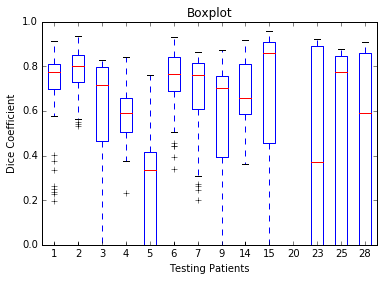

In [17]:
if (bool_generate_boxplot == 1):
	boxplot(dice_total_testing, list_testing_wml)

In [18]:
%%HTML
<h1>Color Maps</h1>

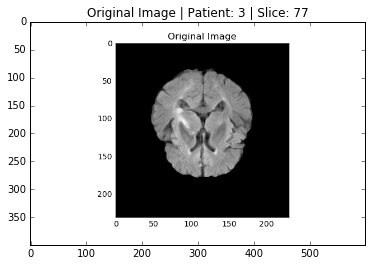

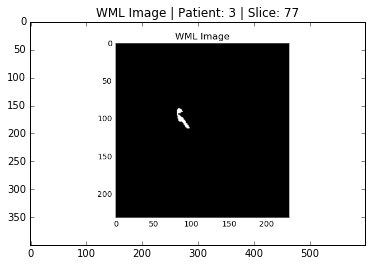

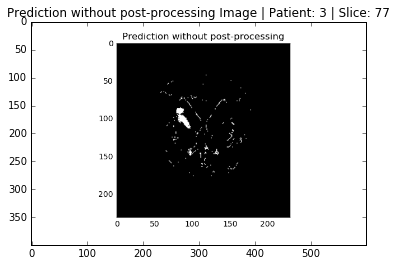

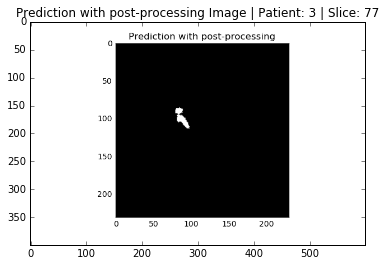

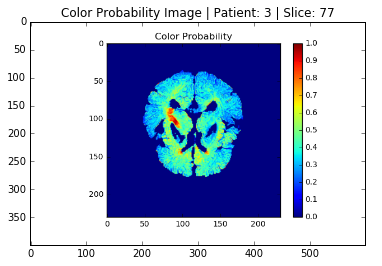

In [19]:
if (bool_generate_color_maps_show == 1 and bool_generate_color_maps == 1):
	path1 = (path_color_maps_folder+str(desired_user_id1)+"/"+str(desired_slice1))
	path2 = (path_color_maps_folder+str(desired_user_id2)+"/"+str(desired_slice2))


	path_color_map1 = (path1+"/Original Image.png")
	img_color_map1 = matplotlib.image.imread(path_color_map1)
	plt.title("Original Image | Patient: "+str(desired_user_id1)+" | Slice: "+str(desired_slice1))
	plt.imshow(img_color_map1)
	plt.show()
	
	path_color_map1 = (path1+"/WML Image.png")
	img_color_map1 = matplotlib.image.imread(path_color_map1)
	plt.title("WML Image | Patient: "+str(desired_user_id1)+" | Slice: "+str(desired_slice1))
	plt.imshow(img_color_map1)
	plt.show()

	path_color_map1 = (path1+"/Prediction without post-processing.png")
	img_color_map1 = matplotlib.image.imread(path_color_map1)
	plt.title("Prediction without post-processing Image | Patient: "+str(desired_user_id1)+" | Slice: "+str(desired_slice1))
	plt.imshow(img_color_map1)
	plt.show()

	path_color_map1 = (path1+"/Prediction with post-processing.png")
	img_color_map1 = matplotlib.image.imread(path_color_map1)
	plt.title("Prediction with post-processing Image | Patient: "+str(desired_user_id1)+" | Slice: "+str(desired_slice1))
	plt.imshow(img_color_map1)
	plt.show()

	path_color_map1 = (path1+"/Color Probability.png")
	img_color_map1 = matplotlib.image.imread(path_color_map1)
	plt.imshow(img_color_map1)
	plt.title("Color Probability Image | Patient: "+str(desired_user_id1)+" | Slice: "+str(desired_slice1))
	plt.show()






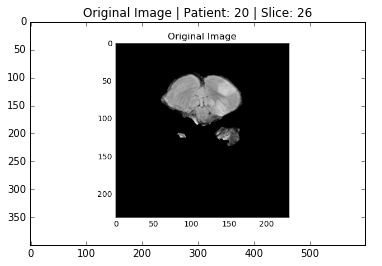

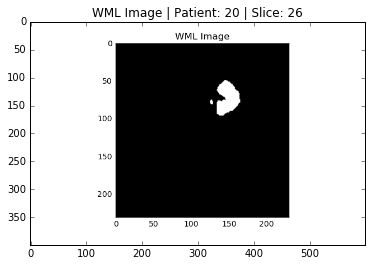

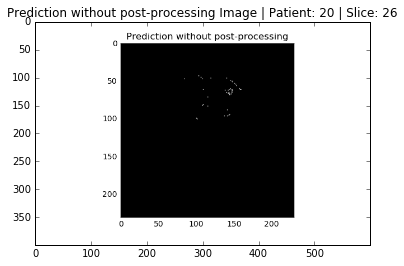

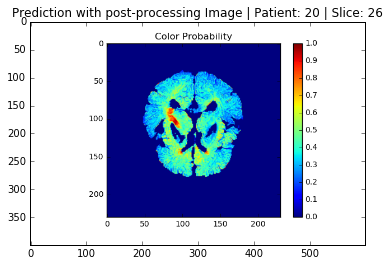

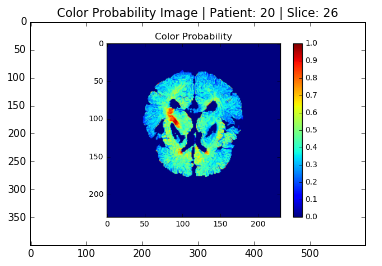

In [20]:
if (bool_generate_color_maps_show == 1 and bool_generate_color_maps == 1):
	path2 = (path_color_maps_folder+str(desired_user_id2)+"/"+str(desired_slice2))

	path_color_map2 = (path2+"/Original Image.png")
	img_color_map2 = matplotlib.image.imread(path_color_map2)
	plt.title("Original Image | Patient: "+str(desired_user_id2)+" | Slice: "+str(desired_slice2))
	plt.imshow(img_color_map2)
	plt.show()
	
	path_color_map2 = (path2+"/WML Image.png")
	img_color_map2 = matplotlib.image.imread(path_color_map2)
	plt.title("WML Image | Patient: "+str(desired_user_id2)+" | Slice: "+str(desired_slice2))
	plt.imshow(img_color_map2)
	plt.show()

	path_color_map2 = (path2+"/Prediction without post-processing.png")
	img_color_map2 = matplotlib.image.imread(path_color_map2)
	plt.title("Prediction without post-processing Image | Patient: "+str(desired_user_id2)+" | Slice: "+str(desired_slice2))
	plt.imshow(img_color_map2)
	plt.show()

	path_color_map2 = (path2+"/Prediction with post-processing.png")
	img_color_map2 = matplotlib.image.imread(path_color_map1)
	plt.title("Prediction with post-processing Image | Patient: "+str(desired_user_id2)+" | Slice: "+str(desired_slice2))
	plt.imshow(img_color_map1)
	plt.show()

	path_color_map2 = (path1+"/Color Probability.png")
	img_color_map2 = matplotlib.image.imread(path_color_map2)
	plt.imshow(img_color_map1)
	plt.title("Color Probability Image | Patient: "+str(desired_user_id2)+" | Slice: "+str(desired_slice2))
	plt.show()

In [21]:
%%HTML
<h1>End of the Program</h1>

In [22]:
write_double_fim()
write_line("End of the program")

deltaTime = (timeit.default_timer() - startTime)
write_line_fim("Execution time: " + str(format(deltaTime, "5.3f")) + " seconds")
close_files()

---------------------------------------------------------
End of the program
-------------
Execution time: 1957.957 seconds
-------------
-------------
